# Setup

In [1]:
!wget https://cdn4.telegram-cdn.org/file/MIEbninRSPGCxXKs7gMw2cEQ8CX7syoN4zEkv9HzVwFrPFQFBDsgdUcVS2Y_T1A3Mko2kPOfWpzzAkZyojNuYp2hMaposainGVKXWKPnq_TuMzqyghc2LQscIavrLIqKl6BEcFkAbuGutNC312OslEKoevtBO_OAvqwGw3sfyTiTeQ15iRocw_HCAKb9VF-dgfDgNFYRTpuxImCm_0mb-Bb_5b46Nj79fPFqdWpcwCcRpPDd6OVdk9X2GMxInfPjhcz_sVZmD11vAJAuXpD-SPlU4sr_VW0PmYggwPoKpw4VH-HzLlylRo03bFyySMtgs3maBLRlF9ipsYGtIUi97w.jpg -O example.jpeg

--2022-10-09 18:47:31--  https://cdn4.telegram-cdn.org/file/MIEbninRSPGCxXKs7gMw2cEQ8CX7syoN4zEkv9HzVwFrPFQFBDsgdUcVS2Y_T1A3Mko2kPOfWpzzAkZyojNuYp2hMaposainGVKXWKPnq_TuMzqyghc2LQscIavrLIqKl6BEcFkAbuGutNC312OslEKoevtBO_OAvqwGw3sfyTiTeQ15iRocw_HCAKb9VF-dgfDgNFYRTpuxImCm_0mb-Bb_5b46Nj79fPFqdWpcwCcRpPDd6OVdk9X2GMxInfPjhcz_sVZmD11vAJAuXpD-SPlU4sr_VW0PmYggwPoKpw4VH-HzLlylRo03bFyySMtgs3maBLRlF9ipsYGtIUi97w.jpg
Resolving cdn4.telegram-cdn.org (cdn4.telegram-cdn.org)... 34.111.35.152
Connecting to cdn4.telegram-cdn.org (cdn4.telegram-cdn.org)|34.111.35.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28173 (28K) [image/jpeg]
Saving to: ‘example.jpeg’

example.jpeg        100%[===================>]  27.51K  --.-KB/s    in 0.001s  

2022-10-09 18:47:31 (50.0 MB/s) - ‘example.jpeg’ saved [28173/28173]



In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.signal import convolve2d

plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["image.cmap"] = "gray"

# Tasks

## Convolution Implementation

In [3]:
def linear_convolution(A, kernel):
    result_shape = np.subtract(A.shape, kernel.shape) + 1
    view_shape = (*result_shape, *kernel.shape)

    view = np.lib.stride_tricks.as_strided(A, view_shape, A.strides * 2)
    conv = np.tensordot(view, kernel)
    return conv

In [4]:
A = np.random.randn(32, 32)
kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

assert np.all(np.isclose(
    linear_convolution(A, kernel), convolve2d(A, kernel, "valid")
))

## Read an image

In [5]:
image = cv2.imread("example.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

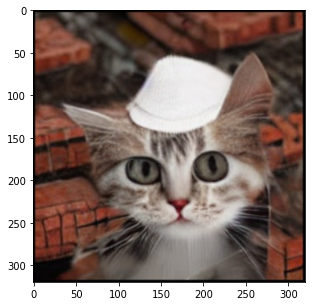

In [6]:
plt.imshow(image);

## To Tensor and Back

In [7]:
tensor = torch.tensor(image)
assert np.all(np.isclose(tensor.numpy(), image))

## Filters

### Gaussian Filter

In [8]:
from scipy import signal

def gkern(kernlen, std):
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)

    gkern2d = gkern2d / gkern2d.sum()
    return gkern2d

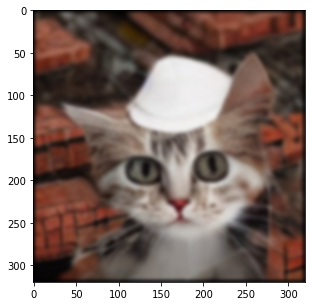

In [9]:
gaussian_kernel = gkern(9, 2)

plt.imshow(cv2.filter2D(image, -1, gaussian_kernel));

### Box Filter

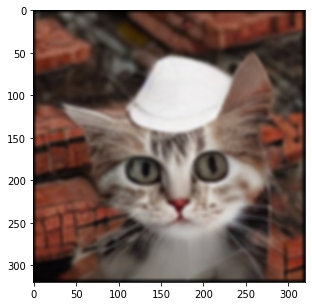

In [10]:
box_filter = np.ones((5, 5))
box_filter = box_filter / np.prod(box_filter.shape)

plt.imshow(cv2.filter2D(image, -1, box_filter));

### Unsharp Masking

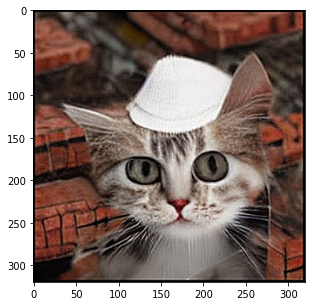

In [11]:
unsharp_masking = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

plt.imshow(cv2.filter2D(image, -1, unsharp_masking));

## Sobel operator

In [12]:
def sobel(A):
    A = cv2.cvtColor(A, cv2.COLOR_RGB2GRAY) / 255

    kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gx = cv2.filter2D(A, -1, kernel)
    Gy = cv2.filter2D(A, -1, np.flip(kernel.T, axis=0))
    G = np.sqrt(Gx**2 + Gy**2)
    G = (G * 255.0 / G.max()).astype("uint8")
    return G

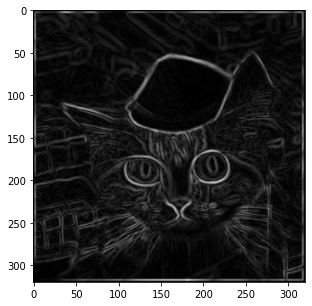

In [13]:
plt.imshow(sobel(image));

## Scaling

### [-1, 1]

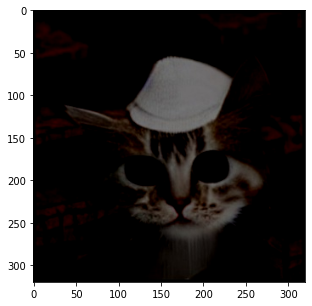

In [14]:
plt.imshow((image - 127.5) / 255);

### ImageNet normalization

In [15]:
imgnet_mean = (0.485, 0.456, 0.406)
imgnet_std = (0.229, 0.224, 0.225)

image_float = image / 255

scaled = (image_float - imgnet_mean) / imgnet_std

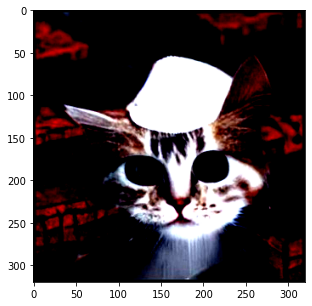

In [16]:
plt.imshow(scaled);